## This is a geographic analysis of the anlysis sent by Tom
1) Load data, and sort it canonically and add GPS values. Save in Temporary
2) Analyze the IBD sharing data. Load from Temporary

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import bisect
from pyproj import Proj  # Package for doing GPS-calculations and Projections
import simplekml   # To export Google Map Files

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as cls
import matplotlib.colorbar as clb
from matplotlib import gridspec
from mpl_toolkits.basemap import Basemap  # For nice plotting of Geography

In [2]:
# Define where to find the files and actually load them:
#ibd_file_path = "../Data/CB10k.ibd30.ibd.txt" # The initial Sample
ibd_file_path = "../Data/IBD_merged/CBchrMAF01.ibd25.ibd"
coordinate_path = "../Data/coordinates/CB108.coordinate.txt"

# Load the IBD data
ibd_data = pd.read_csv(ibd_file_path, index_col=0)
ibd_data.columns = ["Ind1", "HapIndex1", "Ind2", "HapIndex2","Scaffold", "IBDStart", "IBDEnd", "Lod", "IBDlen"]   # Set the column headers

# Sort Ind1 and Ind2 to have canonical ordering!!!
cols = ibd_data[["Ind1", "Ind2"]].values
cols.sort(axis=1)
ibd_data.loc[:,["Ind1", "Ind2"]] = cols

# Load the coordinates
coords = pd.read_csv(coordinate_path, sep="\t")
coords.sort_values(by=['ID']) # Sort as well for canonical ordering

# start doing some simple summary of the data:
nr_ibd_blocks = len(ibd_data)
nr_inds = len(coords)
print("Total Number of IBD Blocks: %i" % nr_ibd_blocks)
print("Total Number of Individuals: %i" % nr_inds)

Total Number of IBD Blocks: 21753
Total Number of Individuals: 108


/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


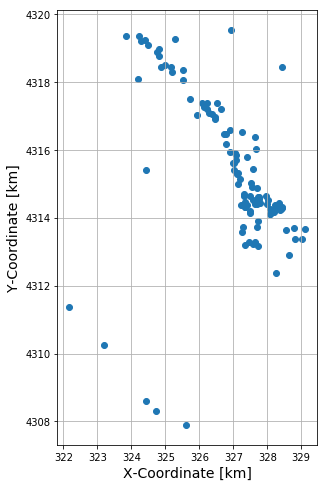

,ID,Latitude,Longitude,Easting,Northing
0,CB001,38.98123,-106.99833,326907.99286,4.316593e+06


In [3]:
# Convert Individual GPS Coordinates into Meters:
# Add altitude

#Prepare the Longitude/Latidude to Easting/Northing transformer:
my_proj = Proj(proj='utm', zone="13S", ellps='WGS84', units='m') 

# Transform all coordinates:

latloncoords = coords[["Latitude","Longitude"]].values

# Transform to xy Coordinates (in Form Easting, Northing)
xy_coords = np.array([my_proj(latloncoords[i,1], latloncoords[i,0]) for i in range(len(latloncoords))])

# Make a Map to plot things nicely:
plt.figure(figsize=(8,8))
plt.scatter(xy_coords[:,0]/1e3, xy_coords[:,1]/1e3)
plt.xlabel("X-Coordinate [km]", fontsize=14)
plt.ylabel("Y-Coordinate [km]", fontsize=14)
plt.axes().set_aspect('equal')
plt.grid(True)
plt.show()

# Add Altititude Values (from Shuttle Data)
# Make this later

# Add Northing and Easting [in meters] to the datasets
coords["Easting"] = xy_coords[:,0]
coords["Northing"] =  xy_coords[:,1]

# Maybe cut out outliers here
coords.head(1)

In [4]:
# Save pre-processed Coordinates to .csv files
coords.to_csv('Intermediate/coords.csv', index=False)        # Ordered coordinates
ibd_data.to_csv("Intermediate/ibd_blocks.csv", index=False)  # Ordered IBD blocks

### Extract Google Maps File  (.kml) to verify the spatial position (optional)

In [37]:
kml = simplekml.Kml()

# First define the Styles (the pins)
style = simplekml.StyleMap()  # Create a style map for highlight style and normal style FOR UNCORRECTED
style.normalstyle.labelstyle.scale = 0
style.normalstyle.iconstyle.icon.href = "http://maps.google.com/mapfiles/kml/pushpin/grn-pushpin.png"
style.highlightstyle.labelstyle.scale = 1
style.highlightstyle.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/pushpin/red-pushpin.png'

print("Creating .kml for %i individuals" % nr_inds)
for i in xrange(nr_inds):
    #if not coords.loc[i, lat_corr_ind]: continue  # Stop if no GPS data    
    lat = coords["Latitude"].iloc[i]
    lon = coords["Longitude"].iloc[i]
    ind_id = coords["ID"].iloc[i]
    
    pnt = kml.newpoint(name=ind_id, coords=[(lon, lat)])   # Could add altitude to lon/lat
    #pnt.description = data[i, comm_ind]
    pnt.stylemap = style
    pnt.altitudemode = 'clamptoground'
    pnt.extrude = 1

kml.save("boechera_samples.kml")
print(".kml successfully generated!")

Creating .kml for 108 individuals


NameError: name 'xrange' is not defined

# Load Pre-Processed Stuff and do Block analysis
Self sustainable from here!

In [2]:
# Save pre-processed Coordinates to .csv files
coords =  pd.read_csv("Intermediate/coords.csv")
ibd_data = pd.read_csv("Intermediate/ibd_blocks.csv")

## Filter out Individuals in the neighboring vally (optional)
There are 5 individuals in the neighboring valley, delete them 

In [3]:
cut_off_lat_min = 38.94 # The cutoff of the longitute. Everything smaller than this is deleted
inds_main = coords["Latitude"] > cut_off_lat_min

print("Deleting %i individuals based on geographic position." % np.sum(~inds_main))
print(coords[~inds_main])

# Identify bad labels
inds_bad = set(coords[~inds_main]["ID"])  # Extract the set of "deleted" individuals
# Deletee the bad columns
coords = coords[inds_main]

# Delete from IBD sharing Dataframe
bad_raws= ibd_data[["Ind1", "Ind2"]].isin(inds_bad).any(axis=1)  # Identify bad raws
print("\nDeleting %i raws from IBD dataframe" % np.sum(bad_raws))
ibd_data = ibd_data[~bad_raws]   # Delete them!

Deleting 5 individuals based on geographic position.
        ID  Latitude  Longitude        Easting      Northing
100  CB475  38.90270 -107.01103  325615.491099  4.307902e+06
101  CB477  38.90610 -107.02152  324714.145346  4.308299e+06
102  CB478  38.90888 -107.02482  324434.828227  4.308614e+06
103  CB479  38.92348 -107.03972  323179.036750  4.310263e+06
104  CB480  38.93335 -107.05157  322176.337434  4.311382e+06

Deleting 1529 raws from IBD dataframe


## Pre-process pairwise distance Matrix to append pw. dists to IBD dataframe. Since it is only 103 to 108 samples, can efficiently do all of them! 
Very quick!!

In [27]:
## Add pairwise distances to IBD block data frame
ids=coords["ID"]

# Create Dataframe with all pairs of Inds:
df_pairs = pd.DataFrame(list(itertools.combinations(ids, r=2)), columns=['Ind1', 'Ind2'])

inds = np.array(list(itertools.combinations(range(len(ids)), r=2)))
# Extract Coordinates 1
coords1 = coords[["Easting","Northing"]].iloc[inds[:,0]].values
# Extract Coordinates 2
coords2 = coords[["Easting","Northing"]].iloc[inds[:,1]].values

# PW. Distance
pwd = np.linalg.norm(coords1 - coords2, axis=1)

# Create the coordinate lists for both inds
df_pairs["pw_dist"]=pwd # Save the pw. Distances in Dataframe


# Calculate all pairwise Distances for all blocks:
# Very quick because join of Databases!

# Merge Data Frames to have pw. distance as an extra field:
data_ibd = pd.merge(ibd_data, df_pairs, on=['Ind1', 'Ind2'], how="left")

## Filter out Individuals that are extremely related
Drop pairs of individuals that share more than 600 cM from pairwise Lists of distances and blocks.
Roughly corresponds to merging them into one individual!

In [28]:
# Generate pairwise statistics:
cut=0.0

df_long = data_ibd[data_ibd["IBDlen"]>cut]
df_stat = df_long.groupby(["Ind1", "Ind2"])['IBDlen'].agg(["count", "sum", "max"])
df_stat.reset_index(inplace=True)   # Reset the Index

print("Unique Pairs that share IBD blocks: %i" % len(df_stat))
print("All pairs: %i " % len(df_pairs))

cut_up = 500
inds = df_stat["sum"] > cut_up
print("Nr of pairs that share more than %i cm blocks: %i" % (cut_up, np.sum(inds)))

# Extract these pairs:
rel_inds = df_stat[["Ind1", "Ind2"]][inds]

###############################################
###############################################
# Delete Individuals that are extremely related


### Delete this special raws from IBD Data Set
k = len(data_ibd)
merged = pd.merge(data_ibd, rel_inds, on=["Ind1", "Ind2"], how='left', indicator=True)

data_ibd = data_ibd[merged['_merge'] == 'left_only']
print("Deleted from %i to %i rows" % (k, len(data_ibd)))

Unique Pairs that share IBD blocks: 4789
All pairs: 5253 
Nr of pairs that share more than 500 cm blocks: 24
Deleted from 20224 to 19945 rows


Nr of Individuals: 103
Analzying blocks from 40.00 to 60.00: 
Analyze 670 of total 19945 blocks
Analzying blocks from 60.00 to 80.00: 
Analyze 477 of total 19945 blocks
Analzying blocks from 80.00 to 100.00: 
Analyze 266 of total 19945 blocks
Analzying blocks from 100.00 to 120.00: 
Analyze 162 of total 19945 blocks


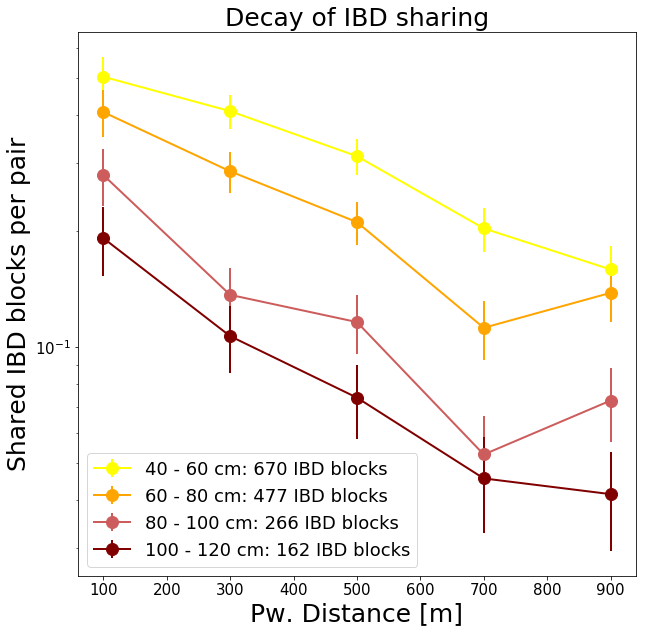

In [29]:
### Plot IBD sharing for different Length Bins
n_bins=5
min_ibd_length=30 # Min Block Length in cm
max_dist = 1000 # Maximum Pairwise Distance [in Meter]

block_categories = [40, 60, 80, 100, 120] # Block boundaries [in kB]!
coords0 = coords[["Easting","Northing"]].values # Extract Numpy array

print("Nr of Individuals: %i" % len(coords0))

def calculate_mean_sharing(min_len, max_len, ibd_data, df_pairs, max_dist):
    '''Calculate the mean sharing in block length bins
    positions: nx2 data, n ... nr Individuals
    ibd_data: Pandas Data Table of ibd-block sharing
    df_pairs: Pandas Data Table of all pairs and their distances
    max_dist: Up to what distance to do analysis
    
    Return: 
    Mean distance per bin, 
    fraction of sharing in Bin
    Error Fraction (Poisson Assumption)
    '''
    ibd_data_0 = ibd_data[(ibd_data["IBDlen"] > min_len) & (ibd_data["IBDlen"] < max_len)]
    nr_blocks0 = len(ibd_data_0)
    print("Analzying blocks from %.2f to %.2f: " % (min_len, max_len))
    print("Analyze %i of total %i blocks" % (nr_blocks0, len(ibd_data)))
    
    # Do the binning:
    counts, bins = np.histogram(ibd_data_0["pw_dist"], range=[-0.01, max_dist], bins=n_bins)  # @UnusedVariable

    # Find proper normalization factors:
    distance_bins = np.zeros(len(bins) - 1)  # Create bins for every element in List; len(bins)=len(counts)+1
    bins[-1] += 0.000001  # Hack to make sure that the distance exactly matching the max are counted
    #         for i in self.start_list[1:]:  # Calculate distance to the first element in start_list for all elements to get proxy for number of comparisons
    #             dist = torus_distance(i[0], i[1], self.start_list[0][0], self.start_list[0][1], self.gridsize)
    #                 
    #             j = bisect.bisect_right(bins, dist)
    #             if j < len(bins) and j > 0:  # So it actually falls into somewhere
    #                 distance_bins[j - 1] += 1    
    
    # Bin distance of every pair for proper normalization factor:
    pw_dist = df_pairs["pw_dist"]
    for dist in pw_dist:        
        # Add pairwise distance to the right bin:
        j = bisect.bisect_right(bins, dist)
        if j < len(bins) and j > 0:  # So it actually falls into somewhere
            distance_bins[j - 1] += 1

    # distance_mean, _, _ = binned_statistic(ibd_data_0["pw_dist"], ibd_data_0["pw_dist"], bins=n_bins, statistic='mean')  # Calculate mean distances for distance bins
    distance_mean=(bins[1:]+bins[:-1])/2.0

    distance_mean = distance_mean[counts != 0]  # Remove bins with no values / MAYBE UPDATE?
    distance_bins = distance_bins[counts != 0]
    counts = counts[counts != 0]
    distance_mean[distance_mean == 0] = 0.001  # In deme case, to account for possibility of bins with dist=0    

    # Poisson-Error:
    error = np.sqrt(counts)
    ibd_frac = [counts[i] / distance_bins[i] for i in range(0, len(counts))]
    ibd_error = [error[i] / distance_bins[i] for i in range(0, len(counts))]  # STD
    return [distance_mean, ibd_frac, ibd_error, nr_blocks0]

### Do the Analysis:
res = []  # Container for the Results

for k in range(len(block_categories)-1):
    temp_res = calculate_mean_sharing(block_categories[k], block_categories[k+1], data_ibd, df_pairs, max_dist)
    res.append(temp_res)

### Plot the results:
plt.figure(figsize=(10,10))
plt.yscale('log')

colors=["Yellow", "Orange", "indianred", "maroon"]
for i in range(len(res)):
    distance_mean, ibd_frac, ibd_error, nr_blocks0 = res[i]
    label = "%.0f - %.0f cm: %i IBD blocks" % (block_categories[i], block_categories[i+1], nr_blocks0)
    plt.errorbar(distance_mean, ibd_frac, ibd_error, marker='o', label=label, markersize=12,
                 linewidth=2, color=colors[i])
#plt.semilogy(x_plot, bessel_decay(x_plot, C1, r1), 'r-.', label="Fitted Bessel decay", linewidth=2)  # Plot of exact fit
plt.xlabel('Pw. Distance [m]', fontsize=25)
plt.ylabel('Shared IBD blocks per pair', fontsize=25)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.legend(prop={'size':18})
plt.title("Decay of IBD sharing", fontsize=25)

# Show simga
#plt.annotate(r'$\bar{\sigma}=%.4G \pm %.2G$' % (sigma_estimate1, sigma_std1) , xy=(0.1, 0.12), xycoords='axes fraction', fontsize=30)

plt.savefig("ibd_geo_decay.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()

## Do histogram of Block Lengths

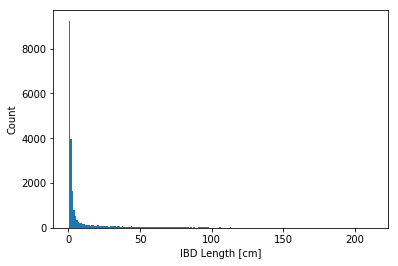

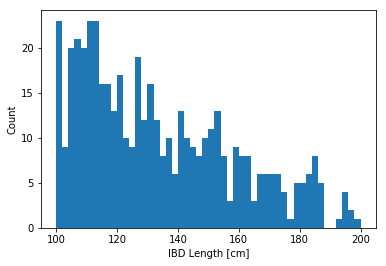

Nr of IBD blocks longer than 1000 kb: 0


In [9]:
plt.figure()
plt.hist(ibd_data["IBDlen"], bins=200)
plt.xlabel("IBD Length [cm]")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(ibd_data["IBDlen"], bins=50, range=(100,200))
plt.xlabel("IBD Length [cm]")
plt.ylabel("Count")
plt.show()


threshold=1000 
nr = np.sum(ibd_data["IBDlen"]/1000.0 > threshold)
print("Nr of IBD blocks longer than %i kb: %i" % (threshold, nr))

## Map Area

### Plot the most related pairs
Plot all pairs that share more than 200 cM in IBD blocks!

In [5]:
### Prepare
### Extract this pairs
cut_up = 300 # The limit in cM to extract
data_ibd = pd.read_csv('Intermediate/ibd_blocks.csv')
df_coords = pd.read_csv('Intermediate/coords.csv', index_col=0)

print("Latidude Spread:")
print(min(df_coords.Latitude))
print(max(df_coords.Latitude))
print("Longitude Spread:")
print(min(df_coords.Longitude))
print(max(df_coords.Longitude))

### Extract most related individuals
# Generate pairwise statistics:
cut=0.0

df_long = data_ibd[data_ibd["IBDlen"]>cut]
df_stat = df_long.groupby(["Ind1", "Ind2"])['IBDlen'].agg(["count", "sum", "max"])
df_stat.reset_index(inplace=True)   # Reset the Index

print("\nUnique Pairs that share IBD blocks: %i" % len(df_stat))
#print("All pairs: %i " % len(df_pairs))


inds = df_stat["sum"] > cut_up
print("Nr of pairs that share more than %i cm blocks: %i" % (cut_up, np.sum(inds)))

# Extract these pairs:
rel_inds = df_stat[["Ind1", "Ind2","sum"]][inds]

Latidude Spread:
38.9027
39.00767000000001
Longitude Spread:
-107.05157
-106.97228

Unique Pairs that share IBD blocks: 5262
Nr of pairs that share more than 300 cm blocks: 138


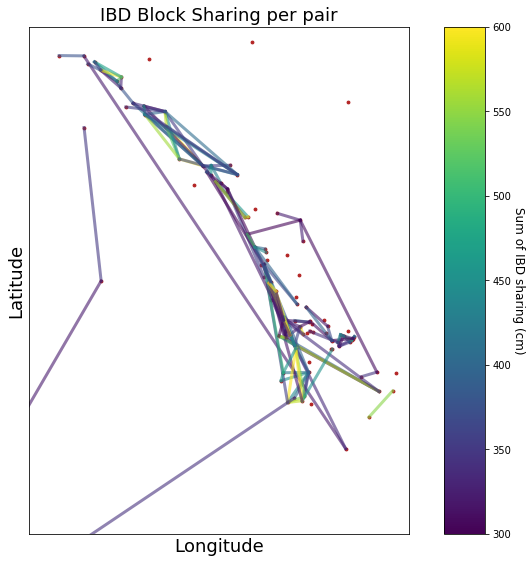

In [6]:
%matplotlib inline
df = df_coords
df_ibd = data_ibd
v_range = [300,600]   # How much IBD blocks are actually shared
fs = 18  # The Fontsize

# Load the relevant fields
lat = df.Latitude.values
lon = df.Longitude.values
label=df.index.values

age=[300, 600] ### CHANGE THIS
# Produce the color Map
cmap0 = cm.get_cmap(name='viridis')
#cmap0 = plt.cm.get_cmap('coolwarm')  # Get custom cmap binary
norm0 = cls.Normalize(vmin=v_range[0], vmax=v_range[1]) # The normaliztion, mapping values to colors between 0 and 1
colors = [cmap0(norm0(i)) for i in age]


###################################
### The interactive Object
class PointBrowser(object):
    """
    Click on a point to select and highlight it -- Information about it will be shown in 
    the lower panel.  Use the 'n'
    and 'p' keys to browse through the next and previous points
    """
    all_visible = False
    
    def __init__(self):
        self.lastind = 0
        self.text = ax.text(0.15, 0.95,'Label: \n Age: \n Index: '  ,
                            transform=ax.transAxes, va='top', fontsize=14)
        
        self.all_text = ax.text(0.75, 0.85,'Nr of Samples: '  ,
                    transform=ax.transAxes, va='top', fontsize=14)

        self.selected, = ax.plot([x[0]], [y[0]], 'o', ms=12, alpha=0.6,
                                 color='darkmagenta', visible=False)
        
        self.all, = ax.plot(x, y, 'o', ms=12, alpha=0.6,
                                 color='red', visible=False)  # highlight all samples
    def onpress(self, event):
        if self.lastind is None:
            return
        
        inc = 0
        if event.key == 'n':
            inc = 1
        elif event.key == "p":
            inc = -1
            
        elif event.key == "a":
            self.show_all()
            
        else:
            return

        self.lastind += inc
        self.lastind = np.clip(self.lastind, 0, len(x) - 1)
        self.update()

    def onpick(self, event):
        #print("First")
        #if event.artist != line:
        #    return True

        N = len(event.ind)
        if not N:
            return True

        # the click locations
        xc = event.mouseevent.xdata
        yc = event.mouseevent.ydata

        distances = np.hypot(xc - x[event.ind], yc - y[event.ind])
        indmin = distances.argmin()
        dataind = event.ind[indmin]

        self.lastind = dataind
        self.update()

    def update(self):
        if self.lastind is None:
            return

        dataind = self.lastind
        #ax2.cla()
        #ax2.plot(X[dataind])
        #ax2.text(0.05, 0.9, 'mu=%1.3f\nsigma=%1.3f' % (xs[dataind], ys[dataind]),
        #         transform=ax2.transAxes, va='top')
        #ax2.set_ylim(-0.5, 1.5)
        self.selected.set_visible(True)
        self.selected.set_data(x[dataind], y[dataind])
        self.text.set_text('Label: %s\n Age: %i \n Index: %i'  % (label[dataind], age[dataind], dataind))
        fig.canvas.draw()
        
    def show_all(self):
        """Shows whole group of current index"""
        # Extract new indices
        inds = np.where(label == label[self.lastind])[0] # Extract the right labels 
        assert(len(inds)>0)
        self.all_visible = not self.all_visible   # Invert visibility!
            
        self.all.set_data(x[inds], y[inds])
        self.all.set_visible(self.all_visible) 
        
        self.all_text.set_text('Nr of samples: %i'  % len(inds))
        #self.all_text.set_visible(self.all_visible)
            

fig = plt.figure(figsize=(8, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[12, 1]) 
ax = plt.subplot(gs[0]) # The left subplot
ax1 = plt.subplot(gs[1]) # The subplot for the axis

#m = Basemap(projection='mill', llcrnrlat=38.9, urcrnrlat=39.01,\
#            llcrnrlon=-107.055, urcrnrlon=-106.97, ax=ax)
m = Basemap(projection='mill', llcrnrlat=38.93, urcrnrlat=39.01,\
            llcrnrlon=-107.04, urcrnrlon=-106.97, ax=ax)


#m.etopo(scale=0.5, alpha=0.4)
m.drawstates()

# Draw paralllels and meridians
#parallels = np.linspace(0.,90, 0.5)
#m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
#meridians = np.linspace(180.,360., 0.5)
#m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)



# Convert all coordinates to basemap coordinates:
coords = np.array([m(lon[i],lat[i]) for i in range(len(lon))])
x,y = np.array(coords[:,0]), np.array(coords[:,1])
#x,y= np.array(lon), np.array(lat)
coll = ax.scatter(x, y, c = "firebrick", alpha=1, picker=True, s=8)
#ine, = ax.plot(x, y, 'o', alpha=1, picker=50)

ax.set_title("IBD Block Sharing per pair", fontsize=fs)
ax.set_xlabel("Longitude", fontsize=fs)
ax.set_ylabel("Latitude", fontsize=fs)

cb1 = clb.ColorbarBase(ax1, cmap=cmap0,
                            norm=norm0,
                            orientation='vertical')
cb1.set_label('Sum of IBD sharing (cm)', fontsize=12, rotation=270, labelpad=14)

# Plot all the highly sharing pairs 
for i1,i2, s in rel_inds.values:
    lat1, lon1 = df_coords.loc[i1,["Latitude", "Longitude"]].values
    lat2, lon2 = df_coords.loc[i2,["Latitude", "Longitude"]].values
    x1, y1 = m(lon1,lat1)
    x2, y2 = m(lon2,lat2)
    
    ax.plot([x1,x2],[y1,y2], color=cmap0(norm0(s), alpha=0.6), linewidth=3)

#ax.set_title('click on point to plot time series')
#line, = ax.plot(xs, ys, 'o', picker=5)  # 5 points tolerance

# Uncomment for clicking!
#browser = PointBrowser()
#fig.canvas.mpl_connect('pick_event', browser.onpick)
#fig.canvas.mpl_connect('key_press_event', browser.onpress)

plt.subplots_adjust(left=0, bottom=0, right=None,
            wspace=-0.1, hspace=0)

plt.savefig("ibd_map.pdf", bbox_inches = 'tight', pad_inches = 0)

plt.show()

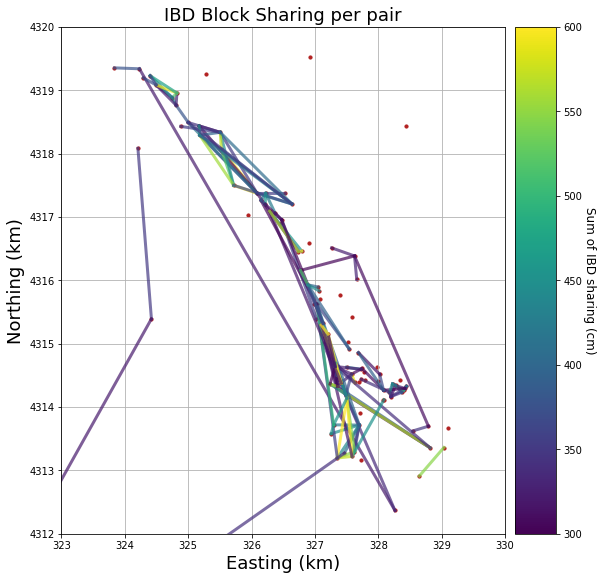

In [10]:
### Do the Plot with m!
%matplotlib inline
df_coords = df_coords
df_ibd = data_ibd
v_range = [300,600]   # How much IBD blocks are actually shared
fs = 18  # The Fontsize

# Load the relevant fields
y = df_coords.Northing.values/1e3
x = df_coords.Easting.values/1e3
label=df.index.values

age=[300, 600] ### CHANGE THIS
# Produce the color Map
cmap0 = cm.get_cmap(name='viridis')
#cmap0 = plt.cm.get_cmap('coolwarm')  # Get custom cmap binary
norm0 = cls.Normalize(vmin=v_range[0], vmax=v_range[1]) # The normaliztion, mapping values to colors between 0 and 1
colors = [cmap0(norm0(i)) for i in age]



###############################
###############################
############ Do the actual Plot

fig = plt.figure(figsize=(8, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[12, 1]) 
ax = plt.subplot(gs[0]) # The left subplot
ax1 = plt.subplot(gs[1]) # The subplot for the axis
ax.grid()

#x,y= np.array(lon), np.array(lat)
coll = ax.scatter(x, y, c = "firebrick", alpha=1, picker=True, s=10)
#ine, = ax.plot(x, y, 'o', alpha=1, picker=50)

ax.set_title("IBD Block Sharing per pair", fontsize=fs)
ax.set_xlabel("Easting (km)", fontsize=fs)
ax.set_ylabel("Northing (km)", fontsize=fs)

###
ax.set_xlim([323,330])
ax.set_ylim([4312,4320])
ax.set_aspect(aspect=1)

### Do the Colorbar
cb1 = clb.ColorbarBase(ax1, cmap=cmap0,
                            norm=norm0,
                            orientation='vertical')
cb1.set_label('Sum of IBD sharing (cm)', fontsize=12, rotation=270, labelpad=14)

# Plot all the highly sharing pairs 
for i1,i2, s in rel_inds.values:
    x1, y1 = df_coords.loc[i1,["Easting", "Northing"]].values/1e3
    x2, y2 = df_coords.loc[i2,["Easting", "Northing"]].values/1e3
    
    ax.plot([x1,x2],[y1,y2], color=cmap0(norm0(s), alpha=0.7), linewidth=3)

plt.subplots_adjust(left=0, bottom=0, right=None,
            wspace=-0.05, hspace=0)

plt.savefig("ibd_map_km.pdf", bbox_inches = 'tight', pad_inches = 0)

plt.show()

# Area 51

In [9]:
# Save pre-processed Coordinates to .csv files
coords =  pd.read_csv("Intermediate/coords.csv")
ibd_data = pd.read_csv("Intermediate/ibd_blocks.csv")

In [10]:
ibd_data.head(10)

,Ind1,HapIndex1,Ind2,HapIndex2,Scaffold,IBDStart,IBDEnd,Lod,IBDlen
0,CB001,1,CB047,1,2,68.842,70.416,3.07,1.574
1,CB001,1,CB047,1,5,74.357,75.360,4.05,1.003
2,CB001,1,CB047,1,6,3.472,6.134,5.78,2.662
3,CB001,1,CB047,2,7,70.674,73.904,3.64,3.230
4,CB001,2,CB061,1,1,7.916,22.253,3.90,14.337
5,CB001,2,CB061,1,2,1.685,3.232,3.32,1.547
6,CB001,1,CB061,2,2,94.504,121.518,14.79,27.014
7,CB001,2,CB061,1,3,32.812,36.442,19.94,3.630
8,CB001,2,CB061,1,3,73.992,75.684,6.55,1.692
9,CB001,1,CB061,2,4,34.912,47.188,11.47,12.276


In [12]:
ids = ["tewst", 'lul']
d = dict(zip(ids, range(len(ids))))

In [20]:
inds = np.array(list(itertools.combinations(range(5), r=2)))
inds

array([[0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [1, 2],
       [1, 3],
       [1, 4],
       [2, 3],
       [2, 4],
       [3, 4]])

In [43]:
i1, i2 = 0, 4
(i2 * (i2 - 1)) / 2 + i1


6.0

In [44]:
l=5
[[i, j] for j in range(0, l) for i in range(0, j)]

[[0, 1],
 [0, 2],
 [1, 2],
 [0, 3],
 [1, 3],
 [2, 3],
 [0, 4],
 [1, 4],
 [2, 4],
 [3, 4]]

In [56]:
min_dist = 0
min_len = 0
f_is = 0

df_coords = pd.read_csv("Intermediate/coords.csv")
df_ibd = pd.read_csv("Intermediate/ibd_blocks.csv")

l = len(df_coords)  # Nr of individuals
k = int(l * (l - 1) / 2)  # Length of the lists
pw_IBD = [[] for _ in range(k)]  # Initialize with empty lists

# Adjust and filter for Block Length:
df_ibd["IBDlen"] = df_ibd["IBDlen"] * (1 - f_is) # correct IBD length!!
df_ibd = df_ibd[df_ibd["IBDlen"] > min_len]


# Create the vector of all pairwise distances and IDs, to quickly look up inds!
ids=df_coords["ID"]
# Create Dataframe with all pairs of Inds:
inds = np.array([[i, j] for j in range(0, l) for i in range(0, j)]) # Create list of pw. Indices, i, j in form 01 02 12 03

coords1 = df_coords[["Easting","Northing"]].iloc[inds[:,0]].values
coords2 = df_coords[["Easting","Northing"]].iloc[inds[:,1]].values

# PW. Distance
pw_dist = np.linalg.norm(coords1 - coords2, axis=1)

# Iterate over all IBD-blocks and append their length for the right individuals

# Send Individuals Labels to their indices
d = dict(zip(ids, range(len(ids))))
i1=df_ibd["Ind1"].map(d)
i2=df_ibd["Ind2"].map(d)

for i1, i2, l in zip(i1, i2, df_ibd["IBDlen"]):
    assert(i2>i1) # Sanity check
    i = (i2 * (i2 - 1)) / 2 + i1
    pw_IBD[int(i)].append(l)  # Append length of shared IBD block

# Set pw. Nr.:
pw_nr = np.ones(k) # Initialize to one

assert(len(pw_dist) == len(pw_IBD))
assert(len(pw_dist) == len(pw_nr))
print("Pair Dist.:")
print(pw_dist[:10])
print("Pair Nr.:")
print(pw_nr[:10])
print("Pair IBD:")
print(pw_IBD[:10])

# Make everything a numpy array
pw_IBD = np.array(pw_IBD)


Pair Dist.:
[ 174.45370859 1059.12769044 1021.62529969 1129.5454481  1149.24408581
  371.00896859 2309.36210003 2207.40283223 3047.6233783  3295.38727301]
Pair Nr.:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Pair IBD:
[[1.574, 1.003, 2.662, 3.23], [14.337, 1.547, 27.014, 3.63, 1.692, 12.276, 0.542, 1.536, 82.568, 30.717], [21.36, 1.63, 1.534, 3.6830000000000003, 65.59100000000001, 0.349, 0.8490000000000001, 50.59], [1.416, 0.54, 0.976, 1.6880000000000002], [16.171, 1.9869999999999999, 45.20399999999999, 5.22, 2.022, 3.46, 19.212, 16.201, 1.486], [5.151, 9.988, 166.791, 17.743, 2.037, 11.478, 0.29600000000000004, 2.906, 4.091], [0.08199999999999999, 1.946, 0.46], [0.386, 0.48, 70.03699999999999, 32.295, 3.398, 0.252, 0.49], [0.68, 0.45299999999999996, 0.78, 0.05], [96.016, 0.768, 1.8630000000000002]]


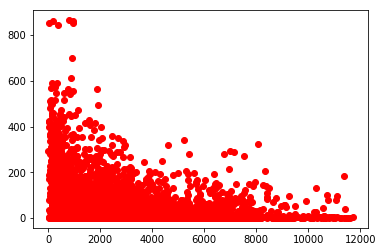

In [69]:
plt.figure()
plt.plot(pw_dist, list(map(np.sum, pw_IBD)), "ro")

In [80]:
df_ibd[(df_ibd.Ind1 == "RP295") & (df_ibd.Ind2 == "RP296")]

,Ind1,HapIndex1,Ind2,HapIndex2,Scaffold,IBDStart,IBDEnd,Lod,IBDlen
21590,RP295,2,RP296,2,2,50.177,50.601,4.72,0.424
21591,RP295,2,RP296,1,4,23.723,23.872,6.85,0.149
21592,RP295,2,RP296,2,5,76.737,77.115,3.28,0.378
21593,RP295,2,RP296,2,7,22.831,22.973,3.09,0.142


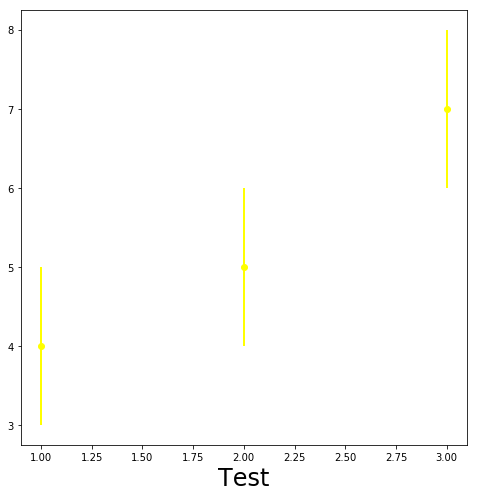

In [22]:
plt.figure(figsize=(8,8))
x=[1,2,3]
y=[4,5,7]
ye=[1,1,1]
plt.errorbar(x, y, yerr=ye, color="yellow", fmt='o', linewidth=2)
plt.xlabel("Test", fontsize=24)
plt.show()